In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy.spatial.distance import pdist
import pickle

import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
from tqdm.notebook import tqdm

from Utils import myUtils as mypy
from Analysis import processQuantStudio as pQS
from Analysis import PYMCutils as pmu


%config InlineBackend.figure_format ='retina'
%config Completer.use_jedi = False
%load_ext Utils.skip_kernel_ext
%load_ext autoreload
%aimport Utils
%aimport Analysis
#%aimport pcr
#pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
code_pth, base_pth, data_pth, rslt_pth, fig_pth = mypy.setupPath()
plt.style.use(str(code_pth / 'Utils' / 'futura_presentation.mplstyle'))

def savemyfig(fig,name,path=fig_pth):
    mypy.savemyfig(fig,'JG047 '+name,path)

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Load in parameter estimates

In [4]:
genes = ['GBP6','TMCC1','ARG1']
gene_coords = {'GBP6':0,'TMCC1':1,'ARG1':2}
palette = sns.cubehelix_palette(light=0.95)

In [5]:
def remove_unreliable(df, n=2):
    '''removes n targets with the highest variation in amplification rate'''
    unreliable = (df
                  .query('Parameter=="r"')
                  .groupby(['Gene','Tar'])['mean']
                  .describe()
                  .apply(lambda row: row['75%']-row['25%'], axis=1)
                  .sort_values()[-n:]
                  .index.to_list()
                 )
    remove = (sum(
        df.apply(lambda row: (row.Gene,row.Tar), axis=1) == pair
        for pair in unreliable).astype(bool))
    df = df[~remove]
    return df

In [6]:
evagreen_ests = pd.read_pickle(data_pth / 'JG045 Reaction Parameters.pkl')
#evagreen_ests = remove_unreliable(evagreen_ests,n=3)
probe_ests = pd.read_pickle(rslt_pth / 'JG047 Reaction Parameters.pkl')
#probe_ests = remove_unreliable(probe_ests)
rxn_ests = pd.concat([
    evagreen_ests.assign(Signal='EvaGreen'),
    probe_ests.assign(Signal='Probe'),
])

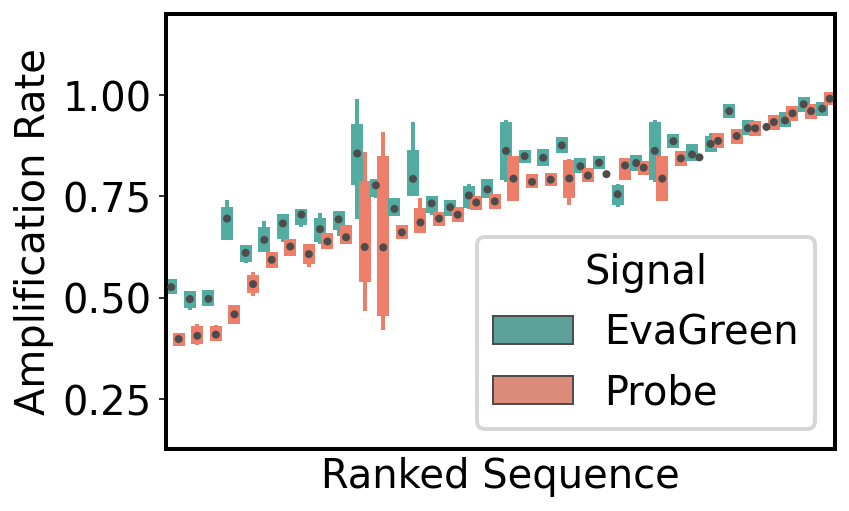

In [117]:
order = (probe_ests
         .query('Parameter=="r"')
         .groupby(['Gene','Tar'])['mean']
         .describe()
         .sort_values('mean')
         .reset_index()
        )['Tar']

specs = dict(
    x='Tar',
    y='mean',
    hue='Signal',
    data = rxn_ests.query('Parameter=="r"'),
    order=order,
    palette=sns.diverging_palette(180, 20, l=65, n=2),
    )

palette=palette=sns.diverging_palette(180, 20, l=65, n=2)
sns.violinplot(**specs)#,alpha=0.5,)
ax = plt.gca()
for a in ax.collections:
    a.remove()
ax.set_xticks([]);
ax.set_xlabel('Ranked Sequence');
ax.set_ylabel('Amplification Rate');
#savemyfig(plt.gcf(),'Ranked Paired EvaGreen and Probe Rates')

In [116]:
ax.lines[4].get_color()

'#4c4c4c'

Saving..Done


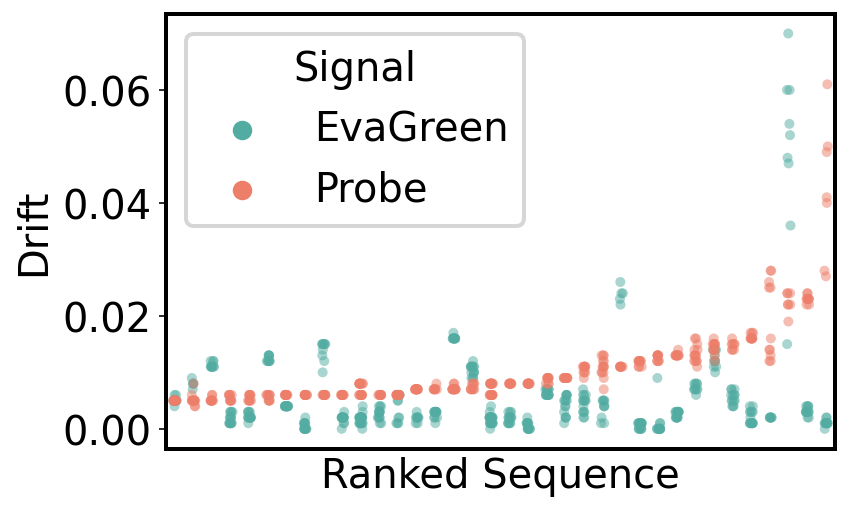

In [40]:
order = (probe_ests
         .query('Parameter=="m"')
         .groupby(['Gene','Tar'])['mean']
         .describe()
         .sort_values('mean')
         .reset_index()
        )['Tar']

specs = dict(
    x='Tar',
    y='mean',
    hue='Signal',
    data = rxn_ests.query('Parameter=="m"'),
    order=order,
    palette=sns.diverging_palette(180, 20, l=65, n=2),
    )

sns.stripplot(**specs,alpha=0.5,)
ax = plt.gca()
ax.set_xticks([]);
ax.set_xlabel('Ranked Sequence');
ax.set_ylabel('Drift');

savemyfig(plt.gcf(),'Ranked Paired EvaGreen and Probe Drifts')

In [42]:
type(sns.diverging_palette(180, 20, l=65, n=2),)

seaborn.palettes._ColorPalette

Saving..Done


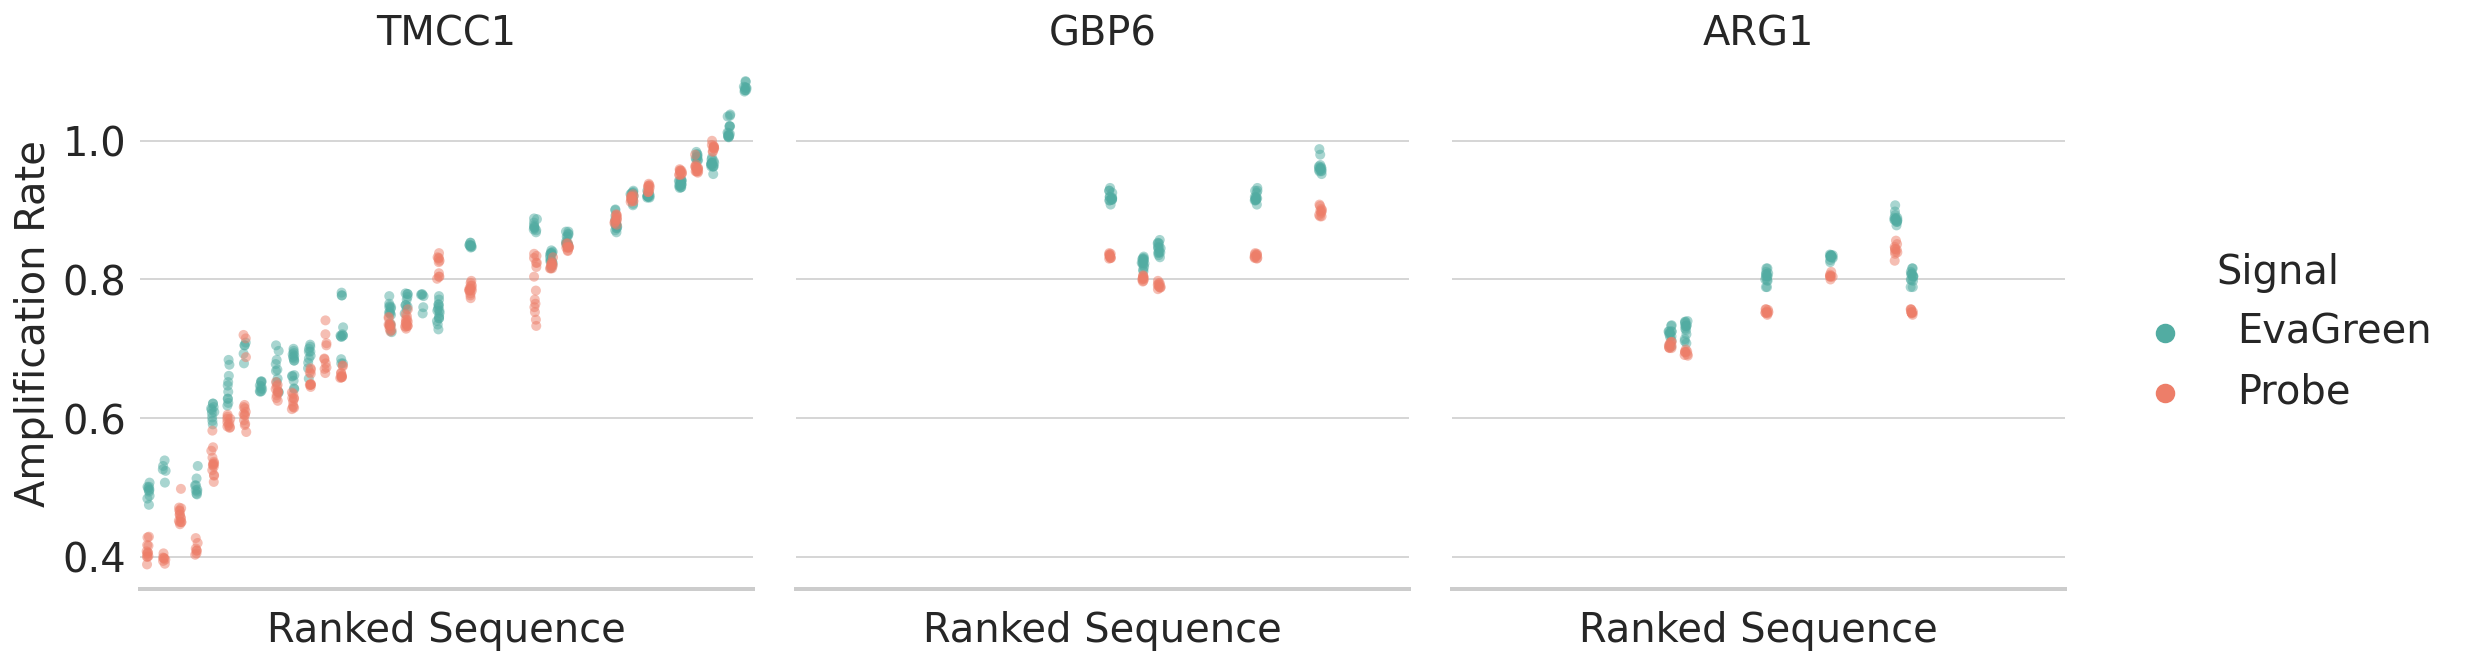

In [8]:
with sns.axes_style("whitegrid"):
    (sns.catplot(**specs,alpha=0.5,col='Gene',kind='strip')
     .set_axis_labels('Ranked Sequence', 'Amplification Rate')
     .set_xticklabels('')
     .set_titles(col_template='{col_name}')
     .despine(left=True)
     .tight_layout()
    )
savemyfig(plt.gcf(),'Ranked Paired EvaGreen and Probe Rates - by gene')

Saving..Done


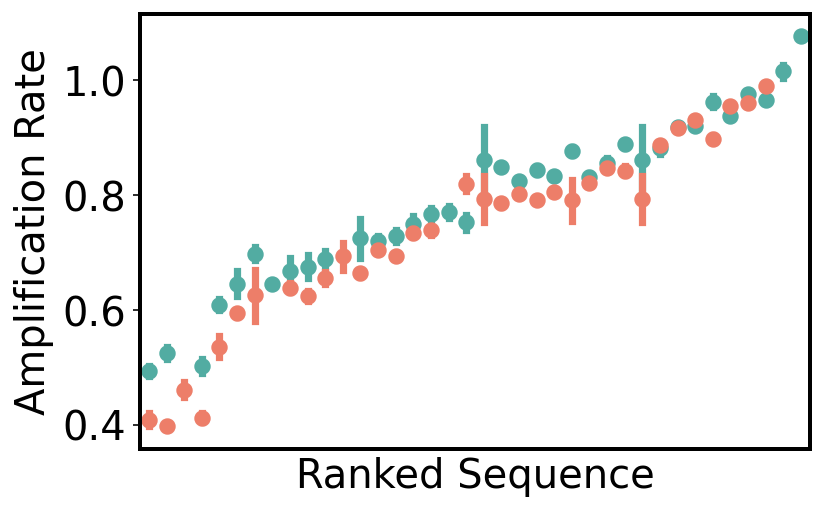

In [9]:
sns.pointplot(**specs,
              #estimator=np.median,
              ci='sd',
              join=False,
              scale=0.7,)
ax = plt.gca()
ax.set_xticks([]);
ax.set_xlabel('Ranked Sequence');
ax.set_ylabel('Amplification Rate');
ax.legend().remove()
savemyfig(plt.gcf(),'Ranked Paired EvaGreen and Probe Rates - mean and sd')

# Coregionalized GP

In [10]:
with open(rslt_pth / 'JG047 Standardizers.pkl','rb') as buff:
    stdzr = pickle.load(buff)['stdzr']
    
stdzr['r'] = dict()
    
stdzr['r'] = {'μ': rxn_ests.query('Parameter=="r"')['mean'].mean(),
              'σ': rxn_ests.query('Parameter=="r"')['mean'].std()}

stdz, unstdz, _, _, get_BP, get_GC = pQS.build_standardizers(stdzr)

In [11]:
r_df = rxn_ests.query('Parameter=="r"')
X = np.vstack([
    r_df.BP_z,
    r_df.GC_z,
    r_df.Gene.replace(gene_coords),
    r_df.Signal=='Probe'
]).T

y = stdz(r_df['mean'],'r').values

BP_distances = pdist(X[:,0][:,None])
GC_distances = pdist(X[:,1][:,None])

ℓ_l_BP = BP_distances[BP_distances!=0].min()
ℓ_u_BP = BP_distances[BP_distances!=0].max()
ℓ_σ_BP = (ℓ_u_BP-ℓ_l_BP)/6
ℓ_μ_BP = ℓ_l_BP + 3*ℓ_σ_BP

ℓ_l_GC = GC_distances[GC_distances!=0].min()
ℓ_u_GC = GC_distances[GC_distances!=0].max()
ℓ_σ_GC = (ℓ_u_GC-ℓ_l_GC)/6
ℓ_μ_GC = ℓ_l_GC + 3*ℓ_σ_GC

ℓ_l_cat = 0.1
ℓ_u_cat = 3
ℓ_σ_cat = (ℓ_u_cat-ℓ_l_cat)/6
ℓ_μ_cat = ℓ_l_cat + 3*ℓ_σ_cat

ℓ_μ = np.array([ℓ_μ_BP,ℓ_μ_GC,ℓ_μ_cat])
ℓ_σ = np.array([ℓ_σ_BP,ℓ_σ_GC,ℓ_σ_cat])

D_in = 4

with pm.Model() as model_joint:
    ℓ = pm.InverseGamma('ℓ', mu=ℓ_μ, sigma=ℓ_σ, shape=D_in-1)
    η = pm.Gamma('η', alpha=2, beta=1)
    cov_EQ = η**2 * pm.gp.cov.ExpQuad(input_dim=D_in, ls=ℓ, active_dims=[0,1,2])

    α_BP = pm.Normal('α_BP', mu=0, sigma=1)
    β_BP = pm.HalfNormal('β_BP', sigma=1)
    cov_Lin = β_BP**2 * pm.gp.cov.Linear(input_dim=D_in, c=α_BP, active_dims=[0])

    W = pm.Normal("W", mu=0, sd=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=D_in, active_dims=[3], kappa=kappa, W=W)
    
    cov = coreg * (cov_EQ + cov_Lin)
    gp = gp_joint = pm.gp.Marginal(cov_func=cov)

    σ = pm.Exponential('σ', lam=1)
    vals = gp.marginal_likelihood('r', X=X, y=y, noise=σ)

    joint_mp = pm.find_MAP()
    #trace_joint = pm.sample()

In [12]:
res = 100
BP_new = np.hstack([
    np.linspace(stdz(10,'BP'), stdz(800,'BP'), res)[:,None],
    np.zeros([res,1])
])
GC_new = np.hstack([
    np.zeros([res,1]),
    np.linspace(stdz(0.075,'GC'), stdz(0.925,'GC'), res)[:,None]
])

new_grids =  BP_grid,GC_grid = np.meshgrid(BP_new[:,0],GC_new[:,1])
new_points = np.vstack([BP_grid.ravel(),GC_grid.ravel()]).T

In [ ]:
    param_stats = (rxn_ests
                   #.query('Parameter=="r" & Signal==@signal')
                   .groupby(['Gene','Gene','BP_z','GC_z','BP','GC','Parameter'])['mean']
                   .describe()
                   .reset_index()
                  )

In [ ]:
surfs_joint = dict()
cmap = 'pink'
av_kws = dict()
av_kws['zlim'] = [0.4,1.2]
av_kws['label'] = 'Amplification Rate'
av_kws['zorder'] = -1
er_kws = dict()
er_kws['vmin'],er_kws['vmax'] = [0.2,1.8]
er_kws['label'] = 'Uncertainty\n(Standard Deviations)'
er_kws['zorder'] = +1

BPticks = [15,25,50,100,200,400]
GCticks = [10,20,40,60,80]

fig, axs = plt.subplots(2,3,figsize=(12,10), sharex=True, sharey=True)

for i,is_probe in enumerate([0,1]):
    signal = ["EvaGreen","Probe"][is_probe]
    param_stats = (rxn_ests
                   .query('Parameter=="r" & Signal==@signal')
                   .groupby(['Gene','Tar','BP_z','GC_z','BP','GC','Parameter'])['mean']
                   .describe()
                   .reset_index()
                  )
    for j,(gene,coord) in enumerate(gene_coords.items()):
        ax = axs[i,j]

        these_points = np.hstack([new_points,
                                  np.full([len(new_points),1],coord),
                                  np.full([len(new_points),1],is_probe)])

        pred_mean, pred_var = gp_joint.predict(these_points, point=joint_mp, diag=True, pred_noise=True)
        pred_mean = pred_mean.T.reshape(res,res)
        pred_mean = surfs_joint[gene] = unstdz(pred_mean,'r')
        pred_err = np.sqrt(pred_var.T.reshape(res,res))
        #pred_err *= stdzr['r']['σ']

        pmu.plot_VSUP(GC_grid, BP_grid, Z_av=pred_mean, Z_err=pred_err, cmap=cmap, ax=ax,
                  av_kws = av_kws, er_kws=er_kws, av_cbar=False, er_cbar=False)

        those = param_stats.query('Gene!=@gene')
        these = param_stats.query('Gene==@gene')

        ax.scatter(those['GC_z'], those['BP_z'], c=those['mean'], cmap=cmap,
                   norm=av_kws['norm'], vmin=av_kws['vmin'], vmax=av_kws['vmax'],
                   ls = ':', ec=[0.15,0.15,0.15], s=10**2, zorder=0);

        ax.scatter(these['GC_z'], these['BP_z'], c=these['mean'], cmap=cmap,
                   norm=av_kws['norm'], vmin=av_kws['vmin'], vmax=av_kws['vmax'],
                   ec='k', s=10**2, zorder=0);

        ax.set_aspect('equal')
        if i==0: ax.set_title(gene)
        ax.set_yticks(stdz(BPticks,'BP'))
        ax.set_xticks(stdz(np.array(GCticks)/100,'GC'))
        ax.set_yticklabels(BPticks)
        ax.set_xticklabels(GCticks)
        #if j == len(gene_coords)-1:
        #    ax2 = ax.twinx()
        #    ax2.set_yticks([])
        #    ax2.set_ylabel(signal)
        #    #ax2.yaxis.set_label_position("right")
        #    #ax2.yaxis.set_label_rotation(180)

        
axs[-1,0].set_ylabel('Length (BP)')
axs[-1,0].set_xlabel('GC Content (%)');
    

#plt.tight_layout();
#savemyfig(plt.gcf(),'All genes - joint VSUP')